Inspired by https://github.com/imgeorgiev/ddp/tree/main

In [1]:
import sympy as sym
import numpy as np
from time import time
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '..')

from ddp import DDPOptimizer
from lqr import LQROPtimizer

### System dynamics

In [2]:
# dynamics parameters
mp = 0.1
mc = 1.0
l = 1.0
G = 9.80665
dt = 0.05

Source: https://coneural.org/florian/papers/05_cart_pole.pdf

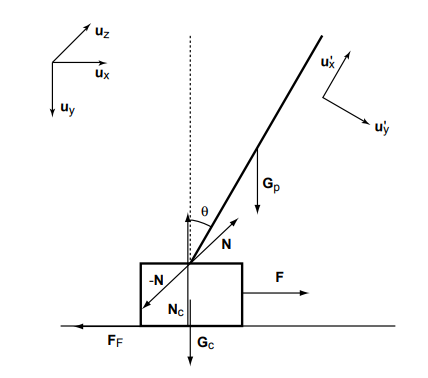

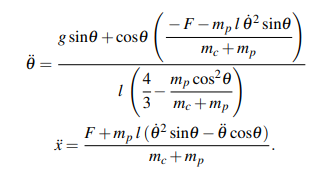

In [3]:
# dynamics
def f(x, u, constrain=True):

    x_ = x[0]
    x_dot = x[1]
    sin_theta = x[2]
    cos_theta = x[3]
    theta_dot = x[4]
    F = sym.tanh(u[0]) if constrain else u[0]

    # Define dynamics model as per Razvan V. Florian's
    # "Correct equations for the dynamics of the cart-pole system".
    # Friction is neglected.

    # Eq. (23)
    temp = (F + mp * l * theta_dot**2 * sin_theta) / (mc + mp)
    numerator = G * sin_theta - cos_theta * temp
    denominator = l * (4.0 / 3.0 - mp * cos_theta**2 / (mc + mp))
    theta_dot_dot = numerator / denominator

    # Eq. (24)
    x_dot_dot = temp - mp * l * theta_dot_dot * cos_theta / (mc + mp)

    # Deaugment state for dynamics.
    theta = sym.atan2(sin_theta, cos_theta)
    next_theta = theta + theta_dot * dt

    return sym.Matrix(
        [
            x_ + x_dot * dt,
            x_dot + x_dot_dot * dt,
            sym.sin(next_theta),
            sym.cos(next_theta),
            theta_dot + theta_dot_dot * dt,
        ]
    )


### Cost

In [4]:
Q_i = np.eye(5)
Q_i[1, 1] = Q_i[4, 4] = 0.0
R = 0.1 * np.eye(1)
Q_t = 100 * np.eye(5)

In [5]:
# instantenious cost
def g(x, u, x_goal):
    error = x - x_goal
    return error.T @ Q_i @ error + u.T @ R @ u

In [6]:
# termination cost
def h(x, x_goal):
    error = x - x_goal
    return error.T @ Q_t @ error

### Simulation

In [7]:
# trajectory parameters
N = 100  # trajectory points
Nx = 5  # state dimension
Nu = 1  # control dimesions

In [8]:
# starting state
x0 = np.array([0.0, 0.0, np.sin(np.pi), np.cos(np.pi), 0.0])

# goal state we want to reach
x_goal = np.array([0.0, 0.0, np.sin(0.0), np.cos(0.0), 0.0])

print("Starting state", x0)
print("Goal state", x_goal)

Starting state [ 0.0000000e+00  0.0000000e+00  1.2246468e-16 -1.0000000e+00
  0.0000000e+00]
Goal state [0. 0. 0. 1. 0.]


#### iLQR

In [9]:
# Create and run optimizer with random intialization
print("Starting optimization")
start_time = time()
ilqr = DDPOptimizer(Nx, Nu, f, g, h)
X, U, X_hist, U_hist, J_hist = ilqr.optimize(x0, x_goal, N=N, full_output=True)
print("Finished optimization in {:.2f}s".format(time() - start_time))

Starting optimization


Finished optimization in 5.07s


Plotting results


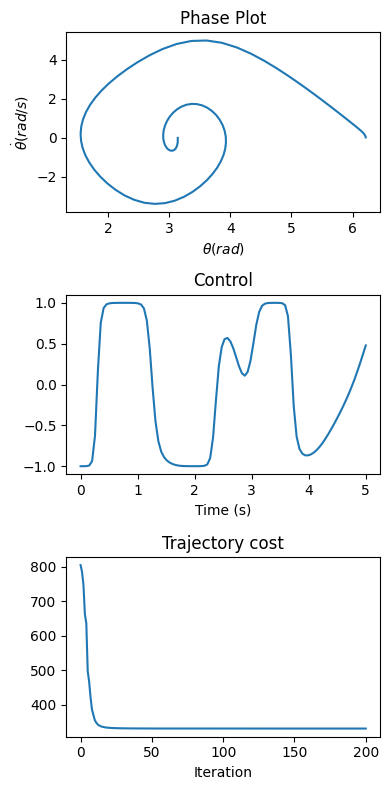

In [10]:
print("Plotting results")
fig, ax = plt.subplots(3, 1, figsize=(4, 8))
tt = np.linspace(0, dt * N, N)
theta_sol = np.unwrap(np.arctan2(X[:, 2], X[:, 3]))
theta_dot_sol = X[:, 4]

ax[0].plot(theta_sol, theta_dot_sol)
ax[0].set_xlabel(r"$\theta (rad)$")
ax[0].set_ylabel(r"$\dot{\theta} (rad/s)$")
ax[0].set_title("Phase Plot")
ax[1].set_title("Control")
ax[1].plot(tt, np.tanh(U))
ax[1].set_xlabel("Time (s)")
ax[2].plot(J_hist)
ax[2].set_title("Trajectory cost")
ax[2].set_xlabel("Iteration")
plt.tight_layout()


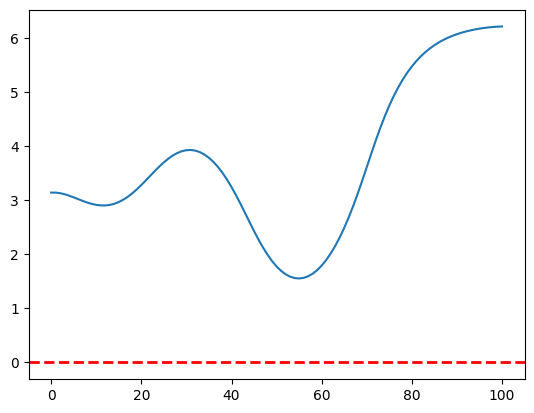

In [11]:
plt.plot(theta_sol)
plt.axhline(y=0.0, xmin=0, xmax=N, linewidth=2, color = 'r', linestyle='--')
plt.show()

#### DDP

In [21]:
# Create and run optimizer with random intialization
print("Starting optimization")
start_time = time()
ddp = DDPOptimizer(Nx, Nu, f, g, h, with_hessians = True)#, alphas = 1.1 ** (-np.arange(10) ** 2), tolerance = 1e-10)
X, U, X_hist, U_hist, J_hist = ddp.optimize(x0, x_goal, N=N, full_output=True)
print("Finished optimization in {:.2f}s".format(time() - start_time))

Starting optimization


<lambdifygenerated-58>:4: RuntimeWarning: overflow encountered in scalar power
  return array([[x0 + 0.05*x1], [0.0454545454545455*u0 + x1 + 0.00454545454545455*x2*x4**2 - 0.00454545454545455*x3*(9.80665*x2 - x3*(0.909090909090909*u0 + 0.0909090909090909*x2*x4**2))/(1.33333333333333 - 0.0909090909090909*x3**2)], [sin(0.05*x4 + arctan2(x2, x3))], [cos(0.05*x4 + arctan2(x2, x3))], [x4 + 0.05*(9.80665*x2 - x3*(0.909090909090909*u0 + 0.0909090909090909*x2*x4**2))/(1.33333333333333 - 0.0909090909090909*x3**2)]])
<lambdifygenerated-58>:4: RuntimeWarning: invalid value encountered in scalar add
  return array([[x0 + 0.05*x1], [0.0454545454545455*u0 + x1 + 0.00454545454545455*x2*x4**2 - 0.00454545454545455*x3*(9.80665*x2 - x3*(0.909090909090909*u0 + 0.0909090909090909*x2*x4**2))/(1.33333333333333 - 0.0909090909090909*x3**2)], [sin(0.05*x4 + arctan2(x2, x3))], [cos(0.05*x4 + arctan2(x2, x3))], [x4 + 0.05*(9.80665*x2 - x3*(0.909090909090909*u0 + 0.0909090909090909*x2*x4**2))/(1.33333333333333 - 

Finished optimization in 0.47s


Plotting results


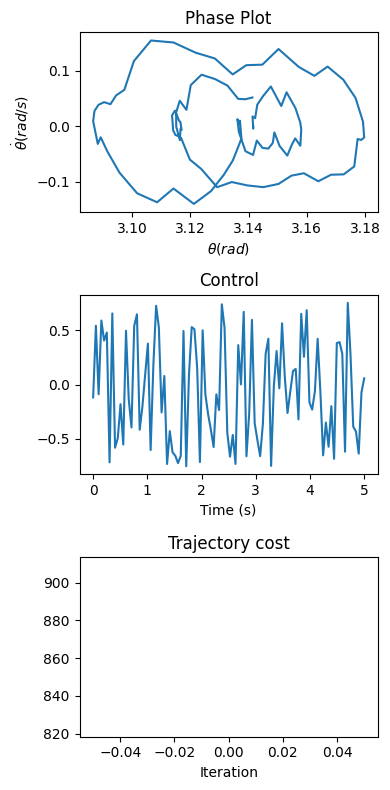

In [22]:
print("Plotting results")
fig, ax = plt.subplots(3, 1, figsize=(4, 8))
tt = np.linspace(0, dt * N, N)
theta_sol = np.unwrap(np.arctan2(X[:, 2], X[:, 3]))
theta_dot_sol = X[:, 4]

ax[0].plot(theta_sol, theta_dot_sol)
ax[0].set_xlabel(r"$\theta (rad)$")
ax[0].set_ylabel(r"$\dot{\theta} (rad/s)$")
ax[0].set_title("Phase Plot")
ax[1].set_title("Control")
ax[1].plot(tt, np.tanh(U))
ax[1].set_xlabel("Time (s)")
ax[2].plot(J_hist)
ax[2].set_title("Trajectory cost")
ax[2].set_xlabel("Iteration")
plt.tight_layout()

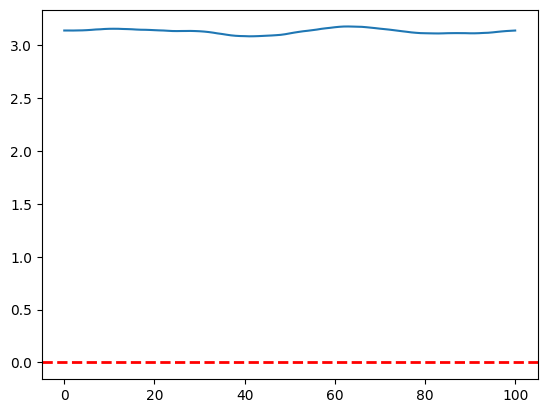

In [23]:
plt.plot(theta_sol)
plt.axhline(y=0.0, xmin=0, xmax=N, linewidth=2, color = 'r', linestyle='--')
plt.show()

#### LQR

In [15]:
# Create and run optimizer with random intialization
print("Starting optimization")
start_time = time()
lqr = LQROPtimizer(Nx, Nu, f, g, h)
X, U, X_hist, U_hist, J_hist = lqr.optimize(x0, x_goal, N=N, full_output=True)
print("Finished optimization in {:.2f}s".format(time() - start_time))

Starting optimization
Finished optimization in 0.16s


Plotting results


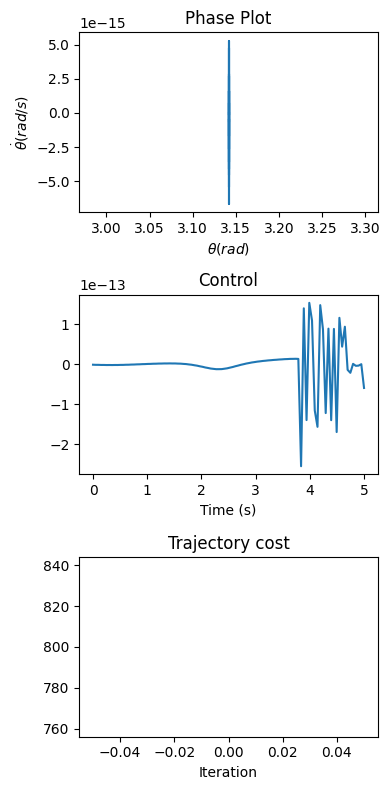

In [16]:
print("Plotting results")
fig, ax = plt.subplots(3, 1, figsize=(4, 8))
tt = np.linspace(0, dt * N, N)
theta_sol = np.unwrap(np.arctan2(X[:, 2], X[:, 3]))
theta_dot_sol = X[:, 4]

ax[0].plot(theta_sol, theta_dot_sol)
ax[0].set_xlabel(r"$\theta (rad)$")
ax[0].set_ylabel(r"$\dot{\theta} (rad/s)$")
ax[0].set_title("Phase Plot")
ax[1].set_title("Control")
ax[1].plot(tt, np.tanh(U))
ax[1].set_xlabel("Time (s)")
ax[2].plot(J_hist)
ax[2].set_title("Trajectory cost")
ax[2].set_xlabel("Iteration")
plt.tight_layout()


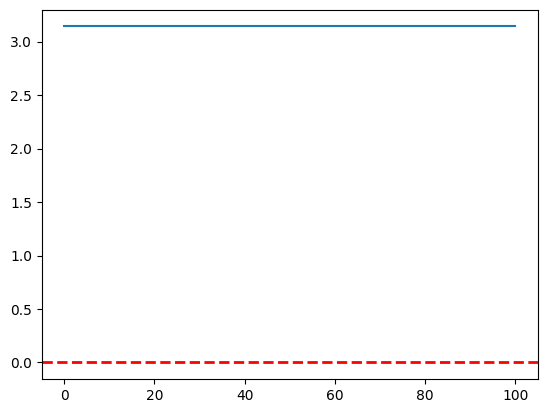

In [17]:
plt.plot(theta_sol)
plt.axhline(y=0.0, xmin=0, xmax=N, linewidth=2, color = 'r', linestyle='--')
plt.show()